# CNN using coronary heart disease data 

This work is aiming at the design and testing of a deep neural network architecture on Coronary heart disease using Tensorflow and Keras.

## Importing libraries

In [2]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

## Reading the data

In [3]:
# read input file
#file = 'E:\\Comsats\\python\\HeartDiseasePrediction\\heartDisease\\4_CardiacPrediction.xlsx'
file = './heartDisease/4_CardiacPrediction.xlsx'
print(file) 
#ipData = pd.read_excel(file, sheet_name='Stroke')
#ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
ipData = pd.read_excel(file)
print(ipData.columns) 

./heartDisease/4_CardiacPrediction.xlsx
Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


## Drop variables

In [4]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)

'''
opLabel = np.array(ipData['Stroke'])
ipData.drop(['SEQN','Stroke','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)
'''



"\nopLabel = np.array(ipData['Stroke'])\nipData.drop(['SEQN','Stroke','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',\n          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)\n"

In [5]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"]) 

varb = np.array(ipData.columns)
ipData = np.array(ipData)

In [6]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 45)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']
35571
1508


## Feature Nomination using LASSO

In [7]:
#Data condensation using LASSO penalty
from sklearn.linear_model import Lasso, LogisticRegression


featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

iteR = 100

for num in range(iteR):
    label0_indx = np.where(opLabel==0)[0]   #no coronary heart disease
    label1_indx = np.where(opLabel==1)[0]   #coronary heart disease 
    numTrainData0 = 1300
    numTrainData1 = 1300
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)
    
    label0_indx_train = label0_indx[0:numTrainData0-1]
    label1_indx_train = label1_indx[0:numTrainData1-1]
    label0_indx_test  = label0_indx[numTrainData0-1:]
    label1_indx_test  = label1_indx[numTrainData1-1:]
    
    testIndx  = np.append(label0_indx_test,label1_indx_test)
    trainIndx = np.append(label0_indx_train,label1_indx_train)    
    trainData  =  ipData[trainIndx]
    trainLabel =  opLabel[trainIndx]
    testData   =  ipData[testIndx]
    testLabel  =  opLabel[testIndx]    
    
    ##%% data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled  = scaler.transform(testData)
    
    ##%% Elastic net and Lasso from scikit
    #regr = ElasticNet(random_state=0, alpha=1, l1_ratio=0.03, tol=0.000001, max_iter=100000)
    regr = Lasso(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    #regr = LogisticRegression(penalty='l1',random_state=0,C=100,tol=0.000001,max_iter=100,class_weight='balanced')
    regr.fit(trainData_scaled,trainLabel)
    cof = np.abs(regr.coef_)    
    colIndx = np.where(cof != 0)[0]
    for col in colIndx:
        featureVote[col]+=1


(45,)


In [8]:
print(featureVote)
print(iter)

[100.  33.  82.  39.  14.  91.  50.  67.   9.  19. 100.  49. 100.  47.
  26.  24.   9. 100.  88.  14.  36.  33. 100.  24.  47.  25. 100.  99.
  96.  95. 100.  59.  86.  73.   5.  87.  49. 100.  60.  14.  13.  89.
   2.  99.  64.]
<built-in function iter>


In [9]:
# feature nomination via Lasso (from feature 1 to 30)
# We keep the dummy variables

#thresH = iteR//5. Pick features occuring more than 5 times
thresH = 0
featureIndx = np.where(featureVote[0:30]>=thresH)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [10]:
featureIndx.shape

(45,)

In [11]:
tInx = np.arange(ipData.shape[1])
rrInx = tInx[~np.isin(tInx,featureIndx)]
print(varb[rrInx])

[]


# Dataset reduction (Re-run every time you change the number of training data)

In [12]:

reduced_data = ipData[:,featureIndx]

label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
label1_indx = np.where(opLabel==1)[0]   #cardiac arrest 
numTrainData0 = 4300
numTrainData1 = 1169
np.random.shuffle(label0_indx)
np.random.shuffle(label1_indx)

label0_indx_train = label0_indx[0:numTrainData0]
label1_indx_train = label1_indx[0:numTrainData1]
label0_indx_test  = label0_indx[numTrainData0:]
label1_indx_test  = label1_indx[numTrainData1:]

testIndx  = np.append(label0_indx_test,label1_indx_test)
trainIndx = np.append(label0_indx_train,label1_indx_train)    
x_train  =  reduced_data[trainIndx]
y_train  =  opLabel[trainIndx]
x_test   =  reduced_data[testIndx]
y_test   =  opLabel[testIndx]    

In [13]:
print(len(label0_indx_test))

31271


In [14]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

x_train_org = copy.deepcopy(x_train)
x_test_org  = copy.deepcopy(x_test)
y_train_org     = copy.deepcopy(y_train)
y_test_org      = copy.deepcopy(y_test)

## t-SNE visualization

In [15]:
# t-SNE visualization
import imblearn
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns

In [16]:
X_embedded = TSNE(n_components=3, n_iter = 300, verbose=1).fit_transform(x_train)


c:\Users\Mubshr07\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Mubshr07\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5469 samples in 0.001s...
[t-SNE] Computed neighbors for 5469 samples in 0.365s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5469
[t-SNE] Computed conditional probabilities for sample 2000 / 5469
[t-SNE] Computed conditional probabilities for sample 3000 / 5469
[t-SNE] Computed conditional probabilities for sample 4000 / 5469
[t-SNE] Computed conditional probabilities for sample 5000 / 5469
[t-SNE] Computed conditional probabilities for sample 5469 / 5469
[t-SNE] Mean sigma: 1.776332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.262047
[t-SNE] KL divergence after 300 iterations: 2.202406


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


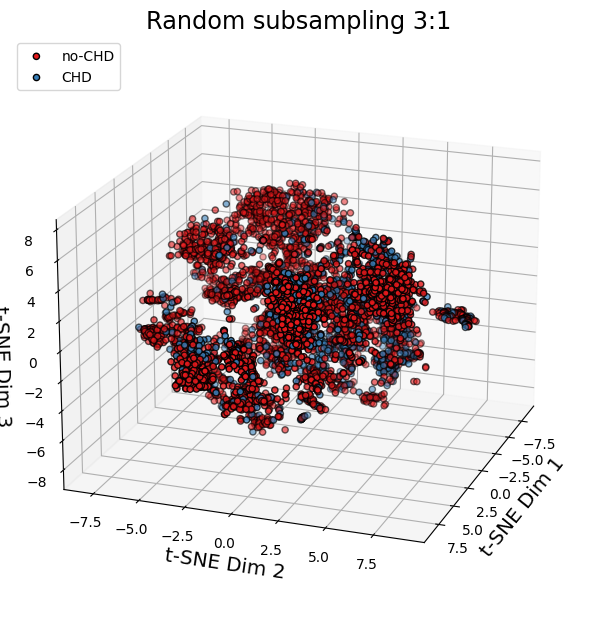

In [17]:
from mpl_toolkits.mplot3d import Axes3D

cin = sns.color_palette("Set1")[1]
edge_color = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('w')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2],c=[sns.color_palette("Set1")[x] for x in y_train],\
           edgecolors='k',label='no-CHD')
ax.scatter(0,0,0,c=cin,edgecolors='k',label='CHD')
ax.azim = 20
ax.elev = 20
ax.set_xlabel("t-SNE Dim 1", size="x-large")
ax.set_ylabel("t-SNE Dim 2", size="x-large")
ax.set_zlabel("t-SNE Dim 3", size="x-large")
plt.title("Random subsampling 3:1",size="xx-large")
ax.legend(loc='upper left')
fig.set_size_inches(7.5,7.5)
fig.savefig('tSNE_RUS.png', dpi=100)

In [18]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [19]:
#%% one-hot-encoding
y_train = keras.utils.to_categorical(y_train,2)
y_test  = keras.utils.to_categorical(y_test,2)

In [20]:
#y_train.shape
#y_train
y_train_org

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

# Running the part above is MANDATORY for training any Network below

## MLP only

In [21]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape (Reshape)           (None, 45)                0         
                                                                 
 dense (Dense)               (None, 512)               23552     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [22]:
class_weight = {0: 1, 1: 10}

myMLP.fit(x_train,y_train,epochs=50,batch_size=500,verbose=1, class_weight=class_weight)

Epoch 1/50
11/11 [==============================] - 1s 12ms/step - loss: 1.6078 - accuracy: 0.6087
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 1.2906 - accuracy: 0.6416
Epoch 3/50
11/11 [==============================] - 0s 9ms/step - loss: 1.1658 - accuracy: 0.6747
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 1.0768 - accuracy: 0.7063
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 1.0265 - accuracy: 0.7062
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 1.0172 - accuracy: 0.7042
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.9603 - accuracy: 0.7180
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.9532 - accuracy: 0.7228
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.9302 - accuracy: 0.7186
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 0.9074 - accuracy: 0.7288
Epoch 11/50
11/11

In [23]:
test_loss,test_acc = myMLP.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 1s 1ms/step - loss: 0.5015 - accuracy: 0.7924
0.7924391031265259


In [24]:
from sklearn import metrics
predlabel = myMLP.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 1s 879us/step
[[24810  6461]
 [  100   239]]


## MLP with additional layers

In [25]:
# MLP -3 :: Input => Hidden(64) => Hidden(128) => Hidden(256)
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)

FC2    = keras.layers.Dense(256, bias_initializer=keras.initializers.VarianceScaling())(DP1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myMLP3 = keras.Model(inputs=inputs,outputs=outputs)
myMLP3.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 45)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2944      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                           

In [26]:
class_weight = {0: 1, 1: 2.2}

myMLP3.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 2s 3ms/step - loss: 0.7130 - accuracy: 0.7563


In [27]:
test_loss,test_acc = myMLP3.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 1s 1ms/step - loss: 0.3336 - accuracy: 0.8551
0.8550775051116943


In [28]:
from sklearn import metrics
predlabel = myMLP3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 1s 835us/step
[[26831  4440]
 [  141   198]]


# Introducing convolutional layers

## MLP+Conv :: Input => Hidden(128)  => Conv(4) => Output (2)

In [29]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D1 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D1.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D1.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_2 (Reshape)         (None, 45)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               5888      
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                           

In [30]:
class_weight = {0: 1, 1: 4}

myCNN1D1.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 2s 3ms/step - loss: 0.9705 - accuracy: 0.6826


In [31]:
test_loss,test_acc = myCNN1D1.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 2s 1ms/step - loss: 0.9334 - accuracy: 0.3968
0.3968048095703125


In [32]:
from sklearn import metrics
predlabel = myCNN1D1.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 1s 1ms/step
[[12219 19052]
 [   15   324]]


##  MLP+CONV: Input => Hidden(128)  => Conv(4) => Conv(8) => Output (2)

In [267]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(8,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2 = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1   = keras.layers.Flatten()(Pool2)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D2 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D2.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 41, 1)]           0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 41)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               5376      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
activation_35 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 128, 1)            0   

In [288]:
class_weight = {0: 1, 1: 4.5}

myCNN1D2.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

Train on 5300 samples
5300/5300 [==============================] - 6s 1ms/sample - loss: 0.6170 - accuracy: 0.8070


In [289]:
test_loss,test_acc = myCNN1D2.evaluate(x_test,y_test)
print(test_acc)


31779/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.7797288


In [290]:
from sklearn import metrics
predlabel = myCNN1D2.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[24629  6942]
 [   58   150]]


## MLP+Conv :: Input => Hidden(64) => Conv(2) => Hidden(512)  

In [82]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(32, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((32,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC2    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D3 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D3.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myCNN1D3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1632      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_5 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 1)             0         
__________

In [215]:
class_weight = {0: 1, 1: 50}

myCNN1D3.fit(x_train,y_train,epochs=5,verbose=1, class_weight=class_weight)

Epoch 1/50
5300/5300 [==============================] - 1s 155us/step - loss: 0.6463 - acc: 0.7902
Epoch 2/50
5300/5300 [==============================] - 1s 142us/step - loss: 0.6470 - acc: 0.7785
Epoch 3/50
5300/5300 [==============================] - 1s 138us/step - loss: 0.6597 - acc: 0.7794
Epoch 4/50
5300/5300 [==============================] - 1s 140us/step - loss: 0.6556 - acc: 0.7813
Epoch 5/50
5300/5300 [==============================] - 1s 136us/step - loss: 0.6609 - acc: 0.7800
Epoch 6/50
5300/5300 [==============================] - 1s 137us/step - loss: 0.6608 - acc: 0.7777
Epoch 7/50
5300/5300 [==============================] - 1s 138us/step - loss: 0.6770 - acc: 0.7808
Epoch 8/50
5300/5300 [==============================] - 1s 144us/step - loss: 0.6473 - acc: 0.7817
Epoch 9/50
5300/5300 [==============================] - 1s 155us/step - loss: 0.6679 - acc: 0.7836
Epoch 10/50
5300/5300 [==============================] - 1s 163us/step - loss: 0.6650 - acc: 0.7783
Epoch 11/

In [216]:
test_loss,test_acc = myCNN1D3.evaluate(x_test,y_test)
print(test_acc)

31779/31779 [==============================] - 2s 52us/step
0.7234337140897953


In [209]:
from sklearn import metrics
predlabel = myCNN1D3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[25009  6562]
 [   63   145]]


## MLP+ CONV: Input => Dense(64) => Conv(2) => Conv(4) = Dense(512) => Dense (2) [Best model]

In [175]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1    = keras.layers.Flatten()(Pool2)

FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(DP3)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN1D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

#myCNN1D4.summary()

In [196]:
class_weight = {0: 1, 1: 2.9}

myCNN1D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

Train on 5469 samples
5469/5469 [==============================] - 2s 415us/sample - loss: 0.7087 - accuracy: 0.7425


In [197]:
test_loss,test_acc = myCNN1D4.evaluate(x_test,y_test)
print(test_acc)


31708/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.77018416


In [198]:
from sklearn import metrics
predlabel = myCNN1D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[24353  7255]
 [   32    68]]


In [17]:
y_train @ np.transpose(np.array([0, 1]))
1/41

0.024390243902439025

## Input => Dense(64) => Conv(2) => Conv(4) = Conv(8) => Dense (2)

In [291]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)


FC3    = keras.layers.Conv1D(6,7,strides=1)(Pool2)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC3)




FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 41, 1)]           0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 41)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2688      
_________________________________________________________________
batch_normalization_30 (Batc (None, 64)                256       
_________________________________________________________________
activation_39 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 64, 1)             0   

In [329]:
class_weight = {0: 1, 1: 3.0}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

Train on 5300 samples
5300/5300 [==============================] - 2s 387us/sample - loss: 0.6142 - accuracy: 0.7885


In [330]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)


31779/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.79388905


In [331]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[25069  6502]
 [   48   160]]


## Input => Dense(64) => Conv(2) => Dense (128) = Conv(4) => Dense (2)

In [333]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FL0 = keras.layers.Flatten()(Pool1)

AA1 = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(FL0)
BB1 = keras.layers.BatchNormalization(axis=-1)(AA1)
CC1 = keras.layers.Activation('relu')(BB1)
Pool2 = keras.layers.Dropout(0.2)(CC1)


RS2    = keras.layers.Reshape((128,1))(Pool2)
FC2    = keras.layers.Conv1D(4,5,strides=1)(RS2)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC2)



FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 41, 1)]           0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 41)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                2688      
_________________________________________________________________
batch_normalization_37 (Batc (None, 64)                256       
_________________________________________________________________
activation_47 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 64, 1)             0  

In [378]:
class_weight = {0: 1, 1: 2.5}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

Train on 5300 samples
5300/5300 [==============================] - 2s 467us/sample - loss: 0.5612 - accuracy: 0.8066


In [379]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)


31779/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.83662164


In [380]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

[[26439  5132]
 [   60   148]]


# Running SVM on the subsampled data

In [33]:
from sklearn.svm import SVC
from sklearn import metrics

svcCAD = SVC(C= 0.05, gamma=1/41, kernel='rbf', class_weight='balanced')
svcCAD.fit(x_train_org,y_train_org)
predlabel = svcCAD.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)

[[22274  8997]
 [   57   282]]


# Running random forest and adaboost

In [171]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
class_weight = {0: 1, 1: 3}
adaboostCAD = AdaBoostClassifier(n_estimators=1000, random_state=0)
adaboostCAD.fit(x_train_org,y_train_org)
predlabel = adaboostCAD.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)

[[28507  3101]
 [   61    39]]


In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#randomforestCAD = RandomForestClassifier(max_depth=3, random_state=0, class_weight='balanced_subsample')

parameters = {'n_estimators': (10,30,50,100,130,160,200), 'max_depth': (2, 3)}
randomforestCAD = GridSearchCV(RandomForestClassifier(random_state=0, class_weight='balanced_subsample'),
                               parameters, cv=5)



randomforestCAD.fit(x_train_org,y_train_org)
#predlabel = randomforestCAD.predict(x_test_org)
#confMat = metrics.confusion_matrix(y_test_org,predlabel)
#print(confMat)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                   

In [173]:
print(randomforestCAD.cv_results_)
print(randomforestCAD.best_estimator_)

{'mean_fit_time': array([0.08282938, 0.29387021, 0.41897631, 0.91056685, 1.08984051,
       1.48873553, 1.74985399, 0.10677276, 0.35040135, 0.55309949,
       0.9704864 , 1.36055346, 1.66107883, 2.0696424 ]), 'std_fit_time': array([0.01321978, 0.04958023, 0.00931091, 0.0808649 , 0.02317977,
       0.17198261, 0.05095598, 0.00560664, 0.05300702, 0.04671714,
       0.0828567 , 0.14032874, 0.12028738, 0.2024198 ]), 'mean_score_time': array([0.00357881, 0.01119542, 0.01858797, 0.03424735, 0.03344407,
       0.04744153, 0.06088629, 0.00200262, 0.01081433, 0.02069693,
       0.03192062, 0.04012713, 0.0544744 , 0.05908551]), 'std_score_time': array([0.00715761, 0.00727246, 0.00299435, 0.00815109, 0.00282151,
       0.00494403, 0.01209187, 0.00400524, 0.00060113, 0.00620093,
       0.00728746, 0.00440803, 0.01475358, 0.00702579]), 'param_max_depth': masked_array(data=[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3],
             mask=[False, False, False, False, False, False, False, False,
         

In [174]:
randomforestCADopt = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

randomforestCADopt.fit(x_train_org,y_train_org)
predlabel = randomforestCADopt.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)


[[23532  8076]
 [   26    74]]


# The following section shows the result when 70% of data are used for training

In [62]:
# With train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(reduced_data, opLabel, test_size = 0.3, random_state = 24)

In [260]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [261]:
#%% one-hot-encoding
Y_train = keras.utils.to_categorical(Y_train,2)
Y_test  = keras.utils.to_categorical(Y_test,2)

In [262]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 39, 1)             0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 39)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               20480     
_________________________________________________________________
batch_normalization_38 (Batc (None, 512)               2048      
_________________________________________________________________
activation_52 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               65664     
__________

In [263]:
np.where(Y_train==0)[0].shape
np.where(Y_train==1)[0].shape


(26017,)

In [280]:
class_weight = {0: 1, 1: 40}

myMLP.fit(X_train,Y_train,epochs=10,batch_size=1200,verbose=1, class_weight=class_weight)

Epoch 1/10
26017/26017 [==============================] - 2s 66us/step - loss: 0.4354 - acc: 0.8823
Epoch 2/10
26017/26017 [==============================] - 2s 65us/step - loss: 0.4301 - acc: 0.8798
Epoch 3/10
26017/26017 [==============================] - 2s 65us/step - loss: 0.4396 - acc: 0.8772
Epoch 4/10
26017/26017 [==============================] - 2s 66us/step - loss: 0.4319 - acc: 0.8824
Epoch 5/10
26017/26017 [==============================] - 2s 66us/step - loss: 0.4439 - acc: 0.8762
Epoch 6/10
26017/26017 [==============================] - 2s 66us/step - loss: 0.4338 - acc: 0.8793
Epoch 7/10
26017/26017 [==============================] - 2s 64us/step - loss: 0.4370 - acc: 0.8830
Epoch 8/10
26017/26017 [==============================] - 2s 66us/step - loss: 0.4202 - acc: 0.8786
Epoch 9/10
26017/26017 [==============================] - 2s 65us/step - loss: 0.4360 - acc: 0.8829
Epoch 10/10
26017/26017 [==============================] - 2s 65us/step - loss: 0.4170 - acc: 0.8762

In [281]:
test_loss,test_acc = myMLP.evaluate(X_test,Y_test)
print(test_acc)

11151/11151 [==============================] - 1s 67us/step
0.8492511882449295


In [282]:
from sklearn import metrics
predlabel = myMLP.predict(X_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(Y_test,axis=1),f)
print(confMat)

[[9237 1450]
 [ 231  233]]


## Logistic Regression

In [211]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = 'lbfgs',max_iter=100000, 
                           class_weight= {0:1, 1:3.0}, verbose=1, random_state = 2)
model = clf.fit(x_train_org,y_train_org)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [212]:
predlabel = model.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)

In [213]:
print(confMat)

[[24286  7322]
 [   26    74]]
